In [1]:
from biological_fuzzy_logic_networks.DREAM import DREAMBioFuzzNet

import torch

import seaborn as sns
import pandas as pd
import numpy as np

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform


/dccstor/ipc1/.conda/envs/biofuzznet2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model=student_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file("/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN.sif")

In [3]:
model.initialise_random_truth_and_output(400)

In [4]:
temp = model.output_states["mek12"].cpu().numpy()

<AxesSubplot:ylabel='Density'>

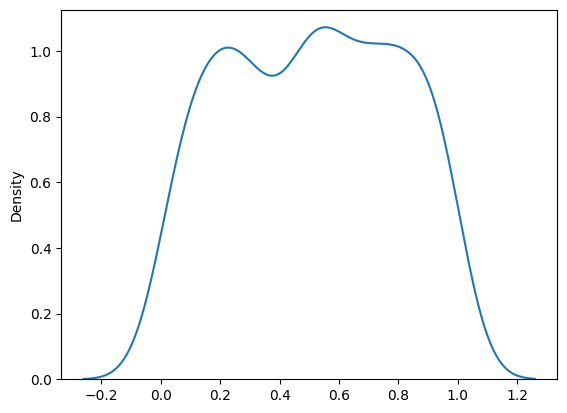

In [5]:
sns.kdeplot(temp.flatten())

In [6]:
model.initialise_random_truth_and_output(400, distribution=Uniform(torch.tensor([0.]), torch.tensor([1.])))

In [7]:
temp = model.output_states["mek12"].cpu().numpy()

<AxesSubplot:ylabel='Density'>

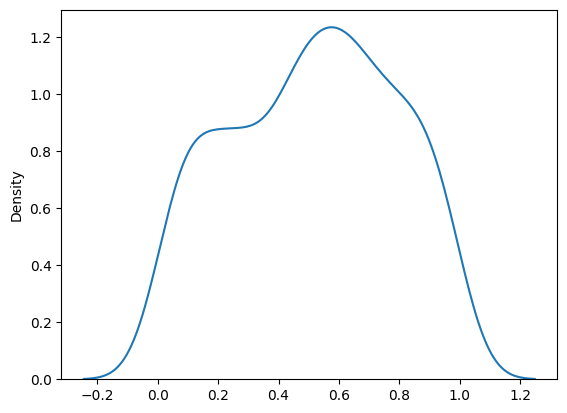

In [8]:
sns.kdeplot(temp.flatten())

In [9]:
model.initialise_random_truth_and_output(400, distribution=Normal(torch.tensor([-0.5]), torch.tensor([0.5])))

In [10]:
temp = model.output_states["mek12"].cpu().numpy()

<AxesSubplot:ylabel='Density'>

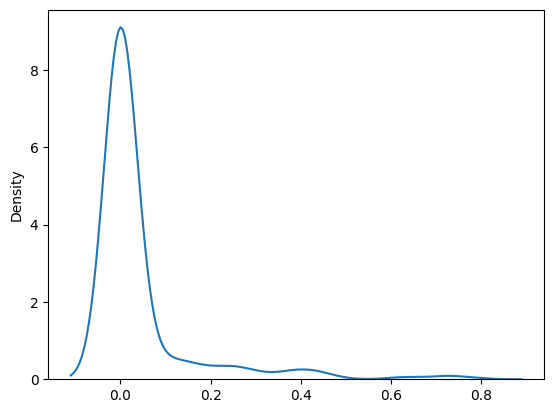

In [11]:
sns.kdeplot(temp.flatten())

In [12]:
sum(temp<0).sum()

0

In [13]:
temp2 = model.output_states["mek12"].cpu()

In [14]:
temp2[(temp2<0)]

tensor([])

In [15]:
temp.flatten().min()

0.0

# Test optimization

In [16]:
pkn_path = "/dccstor/ipc1/CAR/BFN/LiverDREAM_PKN.sif"
train_size=100
train_frac=0.7
BFN_training_params= {
        "epochs": 100,
        "batch_size": 100,
        "learning_rate": 0.001,
        "tensors_to_cuda": True,
        "patience": 5
    }
dist = Normal(torch.Tensor([0.5]), torch.Tensor([0.1]))

In [18]:
teacher_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file(
        pkn_path
)
student_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file(
    pkn_path
)
untrained_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file(
    pkn_path
)

# INHIBITION INPUTS
no_inhibition = {k: torch.ones(train_size) for k in teacher_network.nodes}

# Generate training data without perturbation
with torch.no_grad():
    teacher_network.initialise_random_truth_and_output(train_size, distribution=dist)
    teacher_network.sequential_update(
        teacher_network.root_nodes, inhibition=no_inhibition
    )
    true_unperturbed_data = {
        k: v.numpy().flatten()
        for k, v in teacher_network.output_states.items()
        if k not in teacher_network.root_nodes
    }
    input_data = pd.DataFrame(
        {
            k: v.numpy().flatten()
            for k, v in teacher_network.output_states.items()
            if k in teacher_network.root_nodes
        }
    )

train_true_df = pd.DataFrame(true_unperturbed_data)
input_df = pd.DataFrame(input_data)

# Train student on unperturbed training data
# Split train data in training and validation data
train = train_true_df.sample(frac=train_frac)
val = train_true_df.drop(train.index, axis=0)

train_dict = {c: torch.Tensor(np.array(train[c])) for c in train.columns}
val_dict = {c: torch.Tensor(np.array(val[c])) for c in val.columns}

# Same input as teacher:
train_input = input_df.iloc[train.index, :]
val_input = input_df.drop(train.index, axis=0)

train_input_dict = {
    c: torch.Tensor(np.array(train_input[c])) for c in train_input.columns
}
val_input_dict = {
    c: torch.Tensor(np.array(val_input[c])) for c in val_input.columns
}

# Data should have root nodes and non-root nodes
val_dict.update(val_input_dict)
train_dict.update(train_input_dict)

# Inhibitor
train_inhibitors = {c: torch.ones(len(train)) for c in train_dict.keys()}
val_inhibitors = {c: torch.ones(len(val)) for c in val_dict.keys()}

student_network.initialise_random_truth_and_output(train_size)
losses, curr_best_val_loss, _ = student_network.conduct_optimisation(
    input=train_input_dict,
    ground_truth=train_dict,
    train_inhibitors=train_inhibitors,
    valid_ground_truth=val_dict,
    valid_input=val_input_dict,
    valid_inhibitors=val_inhibitors,
    **BFN_training_params,
)

Loss:6.27e-03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


<AxesSubplot:xlabel='mek12', ylabel='Density'>

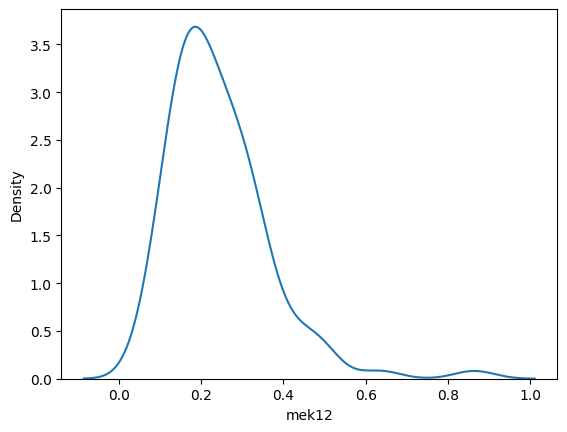

In [21]:
sns.kdeplot(train_true_df["mek12"])

In [22]:
class Bimodal():

    def __init__(self, m1, m2, s1, s2):

        self.norm1 = torch.distributions.normal.Normal(torch.Tensor([m1]), torch.Tensor([s1]))
        self.norm2 = torch.distributions.normal.Normal(torch.Tensor([m2]), torch.Tensor([s2]))


    def sample(self, size):
        sample1=self.norm1.sample(torch.Size([int(np.ceil(size[0]/2))]))
        sample2=self.norm2.sample(torch.Size([int(np.floor(size[0]/2))]))

        return torch.cat((sample1, sample2), 0)
    
    

In [23]:
bimod = Bimodal(0.2, 0.8, 0.1, 0.1)

In [24]:
temp = bimod.sample(torch.Size([400])).numpy()

<AxesSubplot:ylabel='Density'>

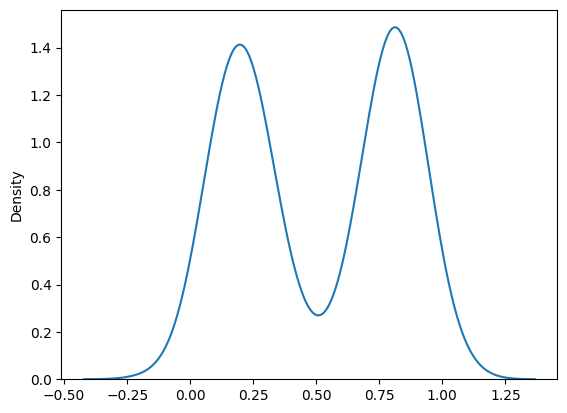

In [25]:
sns.kdeplot(temp.flatten())

In [26]:
teacher_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file(
        pkn_path
)
student_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file(
    pkn_path
)
untrained_network = DREAMBioFuzzNet.DREAMBioFuzzNet.build_DREAMBioFuzzNet_from_file(
    pkn_path
)

# INHIBITION INPUTS
no_inhibition = {k: torch.ones(train_size) for k in teacher_network.nodes}

# Generate training data without perturbation
with torch.no_grad():
    teacher_network.initialise_random_truth_and_output(train_size, distribution=bimod)
    teacher_network.sequential_update(
        teacher_network.root_nodes, inhibition=no_inhibition
    )
    true_unperturbed_data = {
        k: v.numpy().flatten()
        for k, v in teacher_network.output_states.items()
        if k not in teacher_network.root_nodes
    }
    input_data = pd.DataFrame(
        {
            k: v.numpy().flatten()
            for k, v in teacher_network.output_states.items()
            if k in teacher_network.root_nodes
        }
    )

train_true_df = pd.DataFrame(true_unperturbed_data)
input_df = pd.DataFrame(input_data)

# Train student on unperturbed training data
# Split train data in training and validation data
train = train_true_df.sample(frac=train_frac)
val = train_true_df.drop(train.index, axis=0)

train_dict = {c: torch.Tensor(np.array(train[c])) for c in train.columns}
val_dict = {c: torch.Tensor(np.array(val[c])) for c in val.columns}

# Same input as teacher:
train_input = input_df.iloc[train.index, :]
val_input = input_df.drop(train.index, axis=0)

train_input_dict = {
    c: torch.Tensor(np.array(train_input[c])) for c in train_input.columns
}
val_input_dict = {
    c: torch.Tensor(np.array(val_input[c])) for c in val_input.columns
}

# Data should have root nodes and non-root nodes
val_dict.update(val_input_dict)
train_dict.update(train_input_dict)

# Inhibitor
train_inhibitors = {c: torch.ones(len(train)) for c in train_dict.keys()}
val_inhibitors = {c: torch.ones(len(val)) for c in val_dict.keys()}

student_network.initialise_random_truth_and_output(train_size)
losses, curr_best_val_loss, _ = student_network.conduct_optimisation(
    input=train_input_dict,
    ground_truth=train_dict,
    train_inhibitors=train_inhibitors,
    valid_ground_truth=val_dict,
    valid_input=val_input_dict,
    valid_inhibitors=val_inhibitors,
    **BFN_training_params,
)

Loss:1.02e-02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


<AxesSubplot:xlabel='mek12', ylabel='Density'>

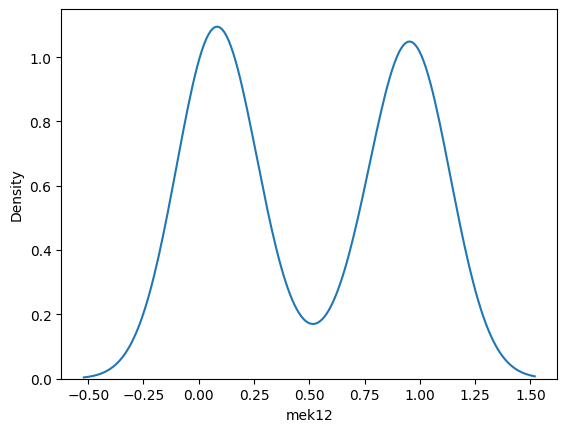

In [28]:
sns.kdeplot(train_true_df["mek12"])

In [27]:
with torch.no_grad():

    test_random_output = {
        k: v.cpu().numpy()
        for k, v in student_network.output_states.items()
        if k not in student_network.root_nodes
    }
    test_random_output_df = pd.DataFrame(
        {k: v for k, v in test_random_output.items()}
    )

In [29]:
test_true_df = pd.DataFrame({k: v for k, v in test_random_output.items()})

<AxesSubplot:xlabel='mek12', ylabel='Density'>

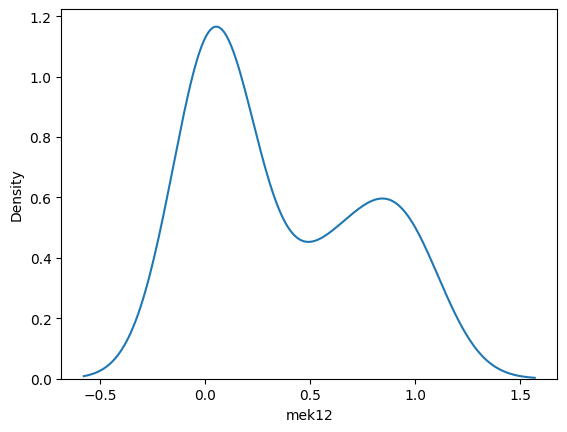

In [30]:
sns.kdeplot(test_true_df["mek12"])

<AxesSubplot:xlabel='mek12', ylabel='Density'>

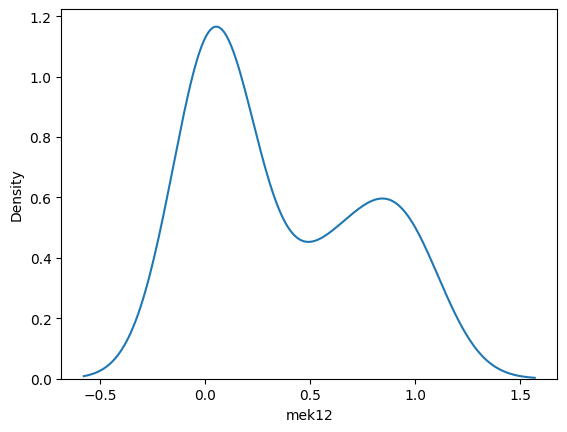

In [31]:
sns.kdeplot(test_random_output_df["mek12"])